<a href="https://colab.research.google.com/github/dugouisse/Task-1/blob/main/CW_PART2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Importing packages
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
import matplotlib.pyplot as plt
import os

In [ ]:

from google.colab import drive

drive.mount('/content/drive',force_remount=True)

BATCH_SIZE = 32
img_height = 180
img_width = 180
 
train_dir = 'drive/MyDrive/imageset_1/imageset/train'
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True, batch_size=BATCH_SIZE, image_size=(img_height, img_width))

validation_dir = 'drive/MyDrive/imageset_1/imageset/val'
val_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,shuffle=True, batch_size=BATCH_SIZE, image_size=(img_height, img_width))


Mounted at /content/drive
Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


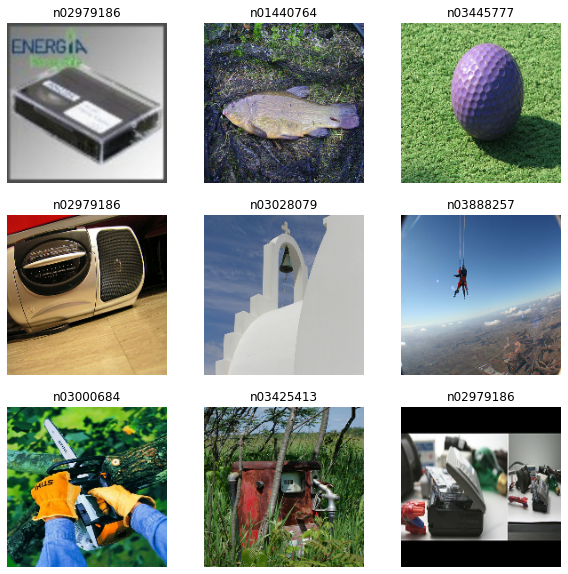

In [ ]:
#preliminary analysis of the data, viewing images of 9 different items. 

import matplotlib.pyplot as plt
%matplotlib inline
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#viewing class names
class_names = train_ds.class_names
print(class_names)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [ ]:
#Prefetching

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
vali_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Data augmentation 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

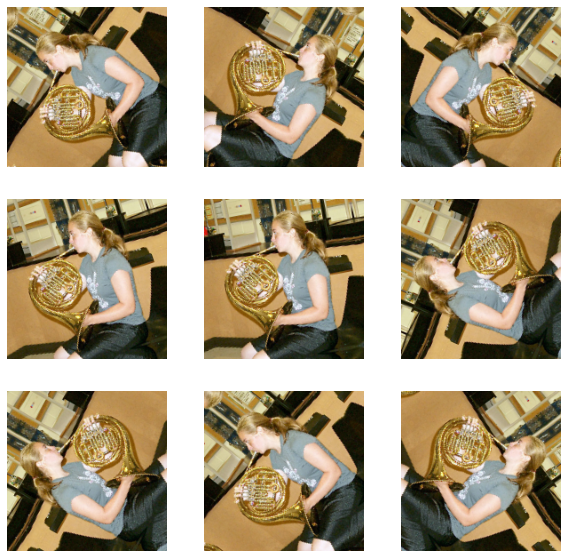

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#Rescaling pixel values to [-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
#Creating base model from pretrained model

IMG_SIZE = (180, 180)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Feature extractor 
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [ ]:
#Freezing convultional base
base_model.trainable = False

In [ ]:
#Summary of base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

In [ ]:
#Adding a pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#Adding a dense layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
#Building a model by adding together the data augmentation, rescaling, base model
#pooling and dense layers
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Compiling model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Summary of model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)


2

In [ ]:
#Training model
initial_epochs = 5

loss0, accuracy0 = model.evaluate(val_ds)

123/123 [==============================] - 470s 4s/step - loss: 0.3547 - accuracy: 0.1050


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.35
initial accuracy: 0.10


In [ ]:
#creating checkpoint to save model to
checkpoint_path = 'training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
#training model
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds, callbacks=[cp_callback])

Epoch 1/5
296/296 [==============================] - ETA: 0s - loss: -30.2915 - accuracy: 0.1081
Epoch 1: saving model to training_1/cp.ckpt
296/296 [==============================] - 1081s 4s/step - loss: -30.2915 - accuracy: 0.1081 - val_loss: -53.5545 - val_accuracy: 0.1006
Epoch 2/5
296/296 [==============================] - ETA: 0s - loss: -91.0789 - accuracy: 0.1009
Epoch 2: saving model to training_1/cp.ckpt
296/296 [==============================] - 422s 1s/step - loss: -91.0789 - accuracy: 0.1009 - val_loss: -106.7485 - val_accuracy: 0.1006
Epoch 3/5
296/296 [==============================] - ETA: 0s - loss: -151.9011 - accuracy: 0.1009
Epoch 3: saving model to training_1/cp.ckpt
296/296 [==============================] - 434s 1s/step - loss: -151.9011 - accuracy: 0.1009 - val_loss: -160.1277 - val_accuracy: 0.1006
Epoch 4/5
296/296 [==============================] - ETA: 0s - loss: -213.1896 - accuracy: 0.1009
Epoch 4: saving model to training_1/cp.ckpt
296/296 [=============

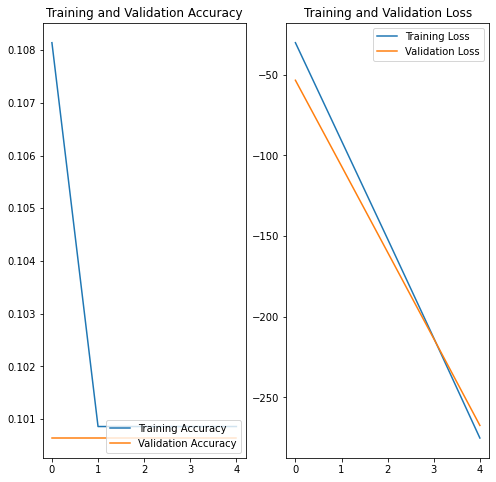

In [ ]:
#Visualising learning curves from model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = initial_epochs
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
images_dir = '/content/drive/My Drive/'
plt.savefig(f"{images_dir}/plot_11.png")
plt.show()



FINE TUNING

In [ ]:
#Unfreezing base model 
base_model.trainable = True

In [ ]:

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#Compiling optimized model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
#Summary of new optimised model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
#training new optimised model
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[cp_callback])

Epoch 5/10
296/296 [==============================] - ETA: 0s - loss: -3423.8740 - accuracy: 0.1009
Epoch 5: saving model to training_1/cp.ckpt
296/296 [==============================] - 558s 2s/step - loss: -3423.8740 - accuracy: 0.1009 - val_loss: -3852.9126 - val_accuracy: 0.1006
Epoch 6/10
296/296 [==============================] - ETA: 0s - loss: -3851.1675 - accuracy: 0.1011
Epoch 6: saving model to training_1/cp.ckpt
296/296 [==============================] - 539s 2s/step - loss: -3851.1675 - accuracy: 0.1011 - val_loss: -3948.5371 - val_accuracy: 0.1024
Epoch 7/10
296/296 [==============================] - ETA: 0s - loss: -3940.4946 - accuracy: 0.1169
Epoch 7: saving model to training_1/cp.ckpt
296/296 [==============================] - 533s 2s/step - loss: -3940.4946 - accuracy: 0.1169 - val_loss: -4036.1450 - val_accuracy: 0.1287
Epoch 8/10
296/296 [==============================] - ETA: 0s - loss: -4026.7014 - accuracy: 0.1363
Epoch 8: saving model to training_1/cp.ckpt
296/

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

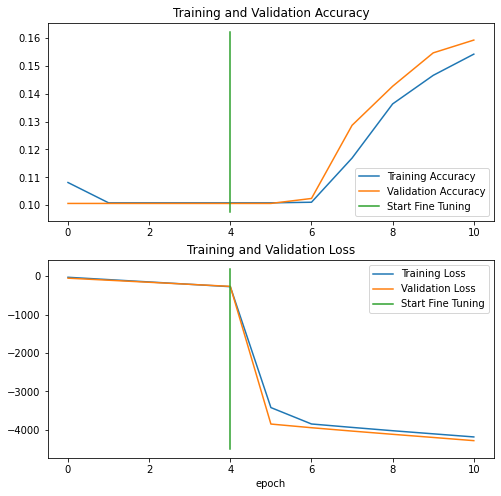

In [ ]:
#Visualising learning curves from new optimised model

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
images_dir = '/content/drive/My Drive/'
plt.savefig(f"{images_dir}/plot_22.png")
plt.show()